# 
- [x] To Do lumen check

# Setup

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os 

import psycopg2
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns 

## import helper

In [2]:
from config_GAM2025 import gam_info

from functions import joining_allWeeks_perChannel
import test_functions 

In [3]:
# week 
week_tester = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='GAM Period')

# country
country_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='CountryID')

# platform codes
platform_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='PlatformID')#[cols]

# service codes
service_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='ServiceID')#[cols]


# Processing


In [4]:
df = pd.read_csv(f"../data/processed/{gam_info['file_timeinfo']}_SiteData.csv", 
                     low_memory=False)
print(df.shape)
df.sample()

(3617583, 8)


,Space,YearGAE,w/c,m_unique_visitors,device_type,ServiceID,PlatformID,PlaceID
3070554,WSLS-Syn-Devices,2025.0,2025-03-03,11.0,Tablet,NaN,WIN,PAK


<Axes: >

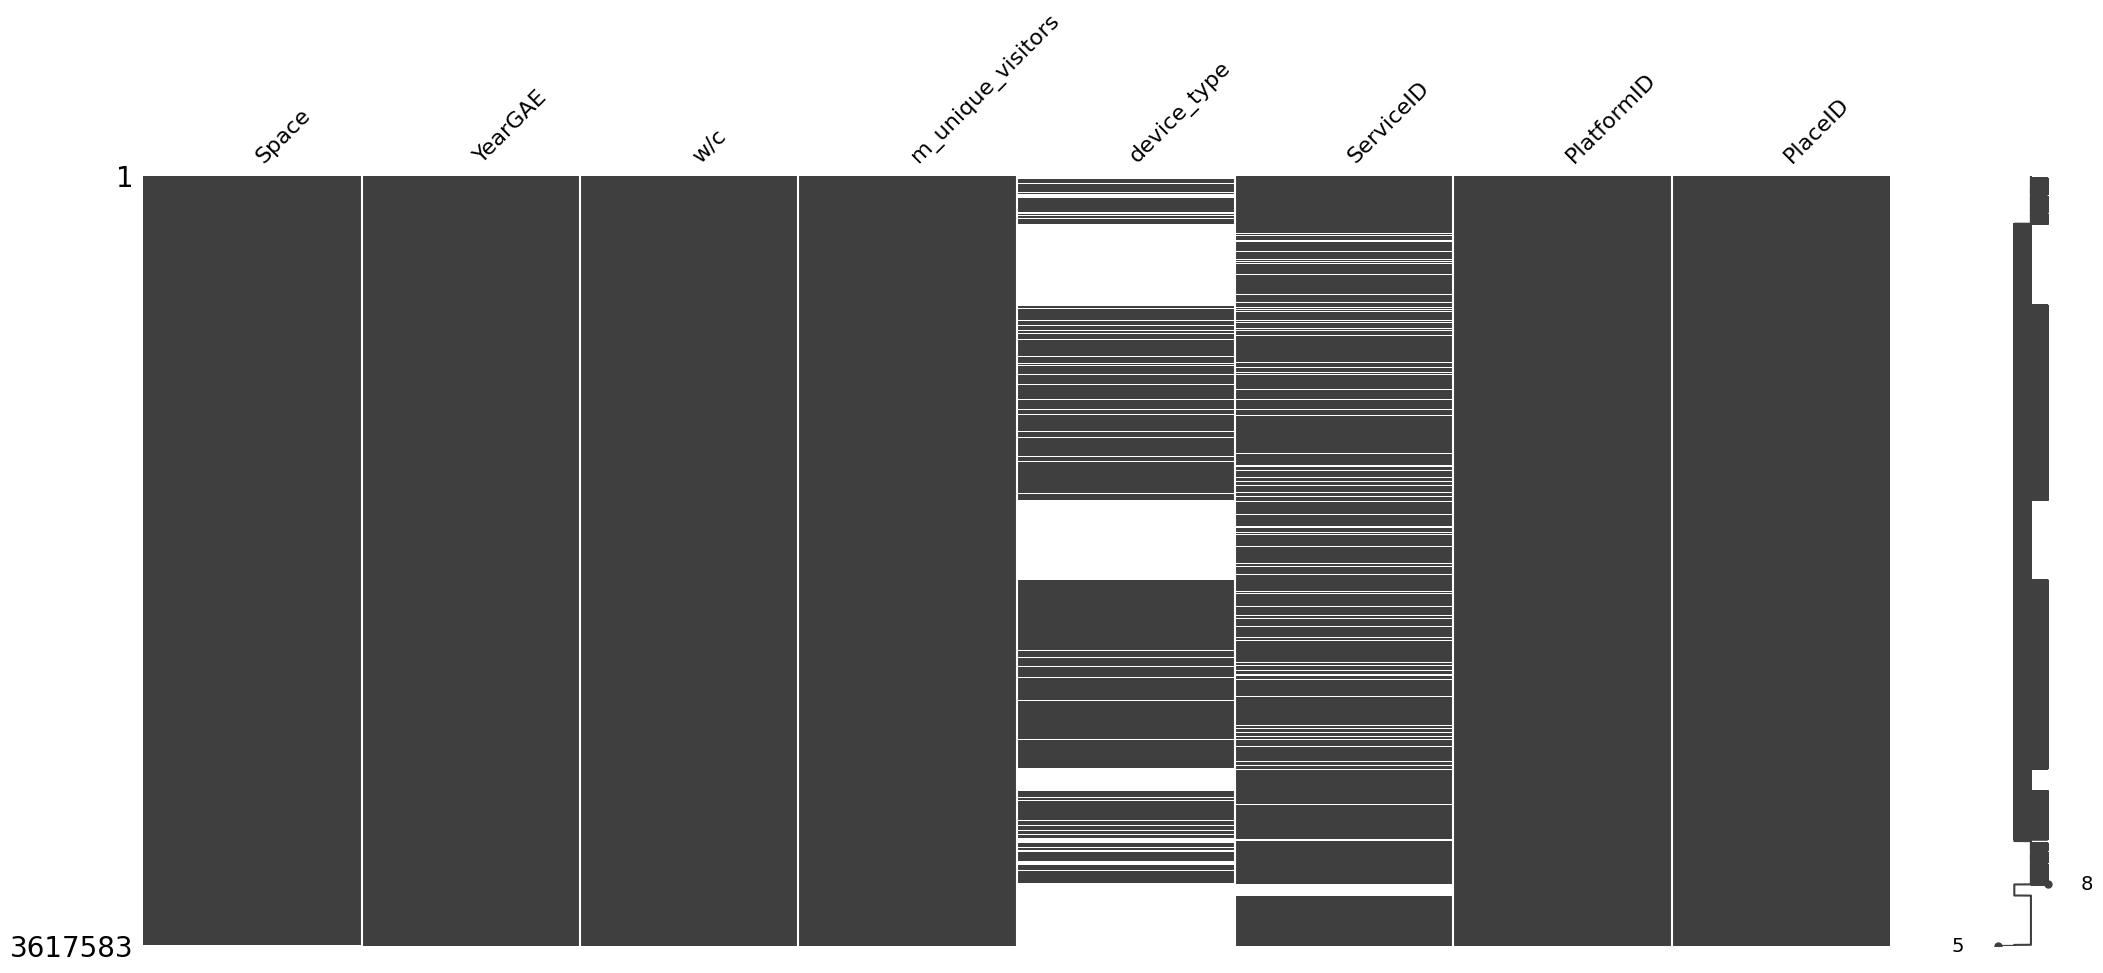

In [5]:
msno.matrix(df)

In [6]:
################################# adding platforms
services_to_add_www = [# device & reach
                        'WSE', 'GNL', 'WOR']

# create Platform WWW from WDI
i = 1
for service in services_to_add_www:
    start = len(df)
    temp = df[(df['ServiceID'] == service) & (df['PlatformID'] == 'WDI')]
    test_val = len(temp)
    temp.loc[:, 'PlatformID'] = 'WWW'
    print(f"{service}: {temp.shape}")
    df = pd.concat([df, temp])
    end = len(df)
    test_number = f"3_site_{i}"
    test_step = f"adding www to {service}"
    test_functions.test_adding_WWW(start, test_val, end, test_number, test_step=test_step, )
    i+=1

WSE: (100256, 8)
passed the test! 
...updating logbook...

GNL: (119561, 8)
passed the test! 
...updating logbook...

WOR: (11509, 8)
passed the test! 
...updating logbook...



In [7]:
################################# remove missing services / places

print('final data:')
display(df.sample())
print(f"with gaps in services and countries: {df.shape}")

df = df[~df['ServiceID'].isna()]
print(f"no missing services: {df.shape}")
df = df[~df['PlaceID'].isna()]
print(f"no missing countries: {df.shape}")

final data:


,Space,YearGAE,w/c,m_unique_visitors,device_type,ServiceID,PlatformID,PlaceID
2302369,WSLS-Direct-Devices,2025.0,2024-05-06,1.0,Mobile Phone,AFA,WDI,NIC


with gaps in services and countries: (3848909, 8)
no missing services: (3436466, 8)
no missing countries: (3436466, 8)


In [8]:
#REACH DATA

# the GNL syndicated stuff doesn't have Space 
df['Space'].fillna('', inplace=True)
# create the inverse of device_factor and keep for much later 
cols = ['YearGAE', 'w/c', 'ServiceID', 'PlatformID', 'PlaceID', 'm_unique_visitors']
reach_data = df[(~df['Space'].str.contains('Devices'))][cols]



/var/folders/gz/pq5c3fbj5rs1tz_5w1hycq4h0000gn/T/ipykernel_38763/2115152766.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Space'].fillna('', inplace=True)


testing splitting df = split does not loose rows (should be True): True
join - row count test 3_Site_6 successful: No issues found.
...updating logbook...



,Space,YearGAE,w/c,PlatformID,PlaceID,ServiceID,Total_Unique_Visitors,Mobile_Unique_Visitors,%_nonMobile,Device Factor 2020,Device Factor 2020 (nonWSL)
240262,WSLS-Direct-Devices,2025.0,2024-08-26,WDI,KOS,AMH,71.0,59.0,0.169014,0.836565,0.836565


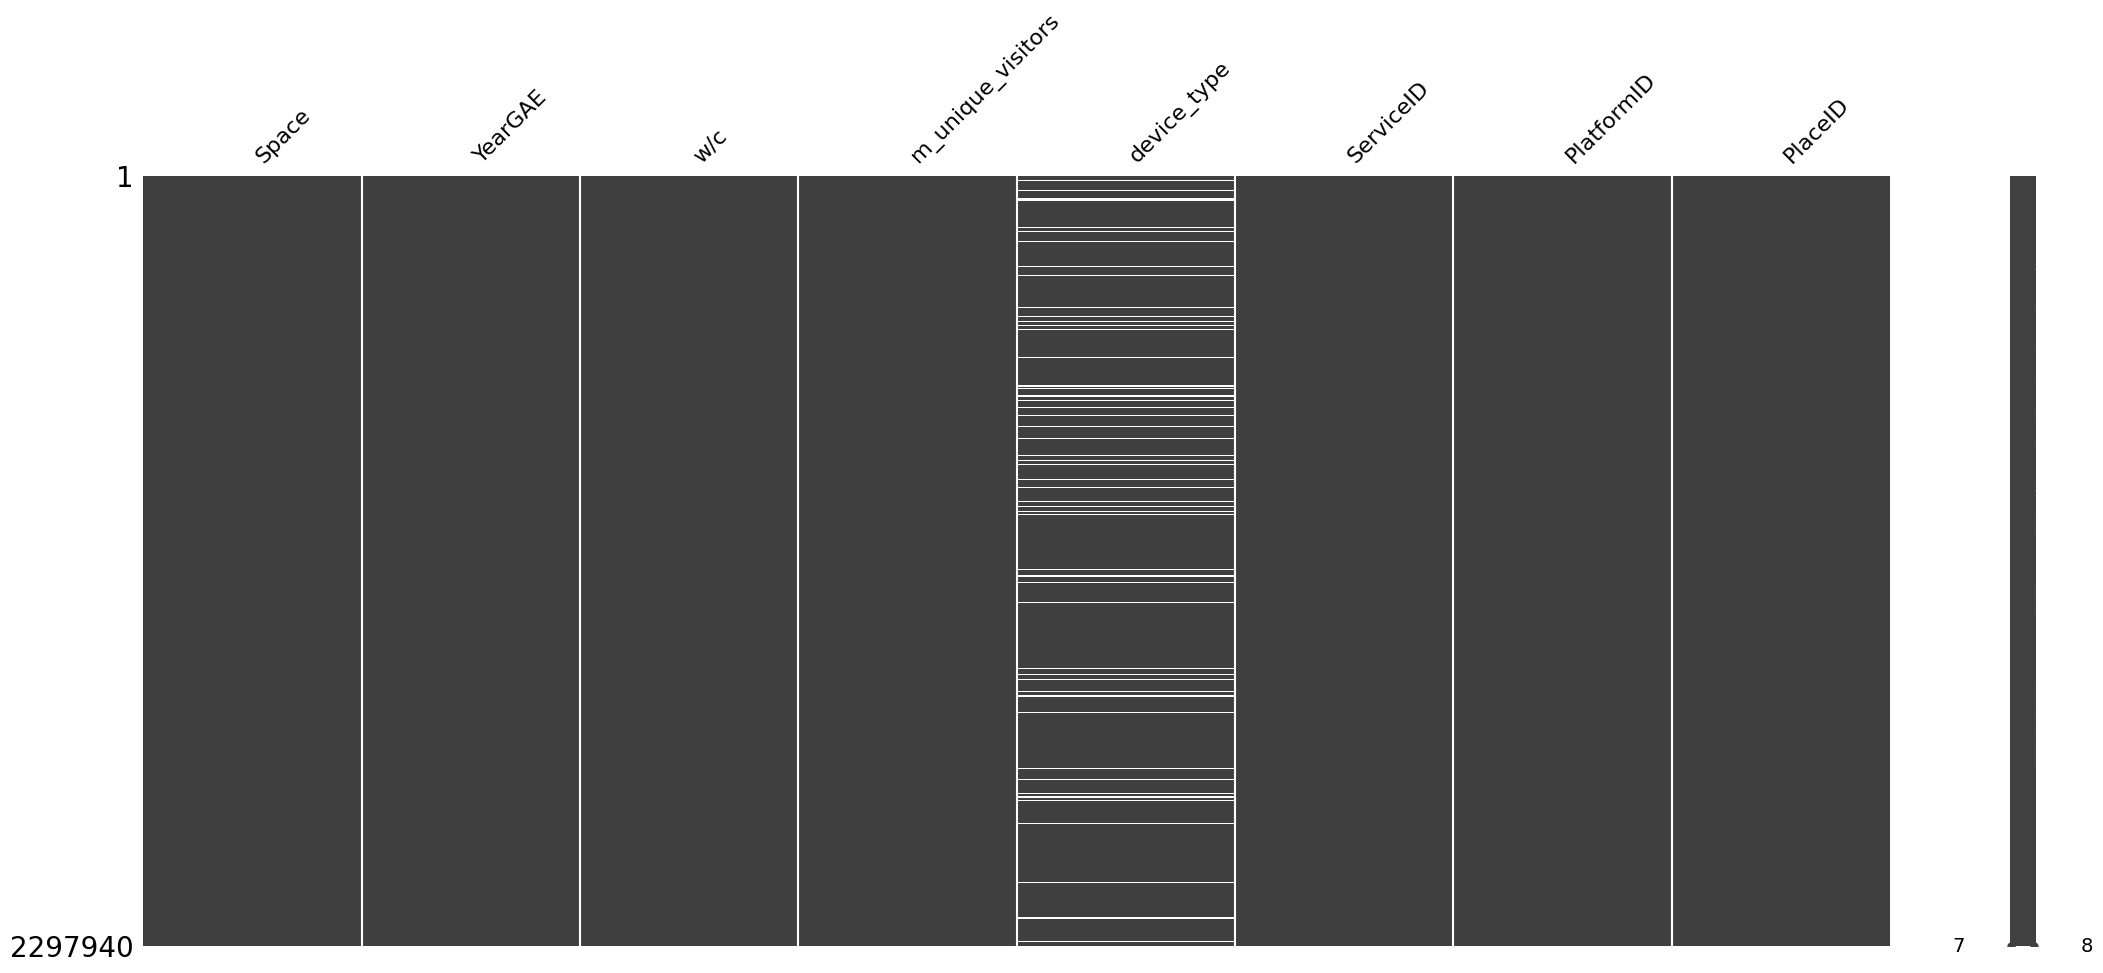

In [9]:

################# Device proportion ~device_type~

device_factor = df[(df['Space'].str.contains('Devices'))]
msno.matrix(device_factor)
#print(device_factor.shape)
print(f"testing splitting df = split does not loose rows (should be True): {device_factor.shape[0] + reach_data.shape[0] == df.shape[0]}")

groupby_cols = ['Space', 'YearGAE', 'w/c', 'PlatformID', 'PlaceID', 'ServiceID']

# a
## filter device_factor by [device_type] IN ('Tablet','Mobile Phone')
mobile_subset = device_factor[device_factor['device_type'].isin((['Tablet','Mobile Phone']))]
## groupby
mobile_subset = mobile_subset.groupby(groupby_cols).agg({
    'm_unique_visitors': 'sum', #Mobile_Unique_Visitors
}).reset_index().rename(columns={'m_unique_visitors': 'Mobile_Unique_Visitors'})

## set Device = Mobile
mobile_subset['Device'] = 'Mobile'
#print(f"mobile subset:")
#display(mobile_subset.sample())

# b
## groupby device_factor - 
device_factor = device_factor.groupby(groupby_cols).agg({
    'm_unique_visitors': 'sum', #Total_Unique_Visitors
}).reset_index().rename(columns={'m_unique_visitors': 'Total_Unique_Visitors'})

## set Device = Total
device_factor['Device'] = 'Total'
#print(f"device factor:")
#display(device_factor.sample())

# c
## inner join by 11 columns
test_functions.test_join_rowCount(device_factor.drop(columns='Device'), mobile_subset.drop(columns='Device'), groupby_cols, 
                               test_number='3_Site_6', 
                               test_step='device factor joining total device and mobile')
device_factor = device_factor.drop(columns='Device').merge(mobile_subset.drop(columns='Device'), on=groupby_cols, how='outer')

## calculate % non mobile
device_factor['%_nonMobile'] = 1-device_factor['Mobile_Unique_Visitors']/device_factor['Total_Unique_Visitors']

##################################### Calculating GWI Site to People Factor (deduplicating devices)
cols = ['PlaceID', 'Device Factor 2020', 'Device Factor 2020 (nonWSL)']
device_factor = device_factor.merge(country_codes[cols], on='PlaceID', how='left')
display(device_factor.sample())

device_factor.fillna({'Device Factor 2020': gam_info['DeviceFactor2020']}, inplace=True)
device_factor.fillna({'Device Factor 2020 (nonWSL)': gam_info['DeviceFactor2020_nonWSL']}, inplace=True)

# List of service codes to check
nonWSL_serviceCodes = ["ANY", "EN2", "ENG", "ALL", "WOR", "TOT", "GNL", "ANW", "WSE", "AX2", "ELT"]

# Create 'final_deviceFactor' column based on the condition
device_factor['final_deviceFactor'] = device_factor.apply(
    lambda row: row['Device Factor 2020 (nonWSL)'] if row['ServiceID'] in nonWSL_serviceCodes 
                                                    else row['Device Factor 2020'],
    axis=1
)

device_factor['Reach_dedupli'] = (device_factor['Total_Unique_Visitors']-device_factor['Mobile_Unique_Visitors'])*device_factor['final_deviceFactor']
#device_factor.to_excel(f"../test/specific/{gam_info['file_timeinfo']}_deviceFactorDetail.xlsx")

# device factor is done on a week / service basis not a country basis 
device_factor = device_factor.groupby(['YearGAE', 'w/c', 'PlatformID', 'ServiceID']).agg({
    'Total_Unique_Visitors': 'sum',
    'Reach_dedupli': 'sum'
}).reset_index()

# Rename the summed columns
device_factor.rename(columns={
    'Total_Unique_Visitors': 'Sum_Total_Unique_Visitors',
    'Reach_dedupli': 'Sum_Reach_dedupli'
}, inplace=True)

device_factor['GWI Site to People Factor'] = device_factor['Sum_Reach_dedupli']/device_factor['Sum_Total_Unique_Visitors']
#device_factor.sample()


,PlatformID,ServiceID,Avg_GWI_Site_to_People_Factor,Count
48,WIN,BUR,0.077318,52


PlatformID,ServiceID,WDI,WIN,WWW
7,ECH,0.250103,NaN,0.250103
0,AFA,0.028055,NaN,0.028055
14,IGB,0.111354,NaN,0.111354
22,PAS,0.084052,NaN,0.084052
29,SIN,0.087576,NaN,0.087576


passed the test! 
...updating logbook...



<Axes: >

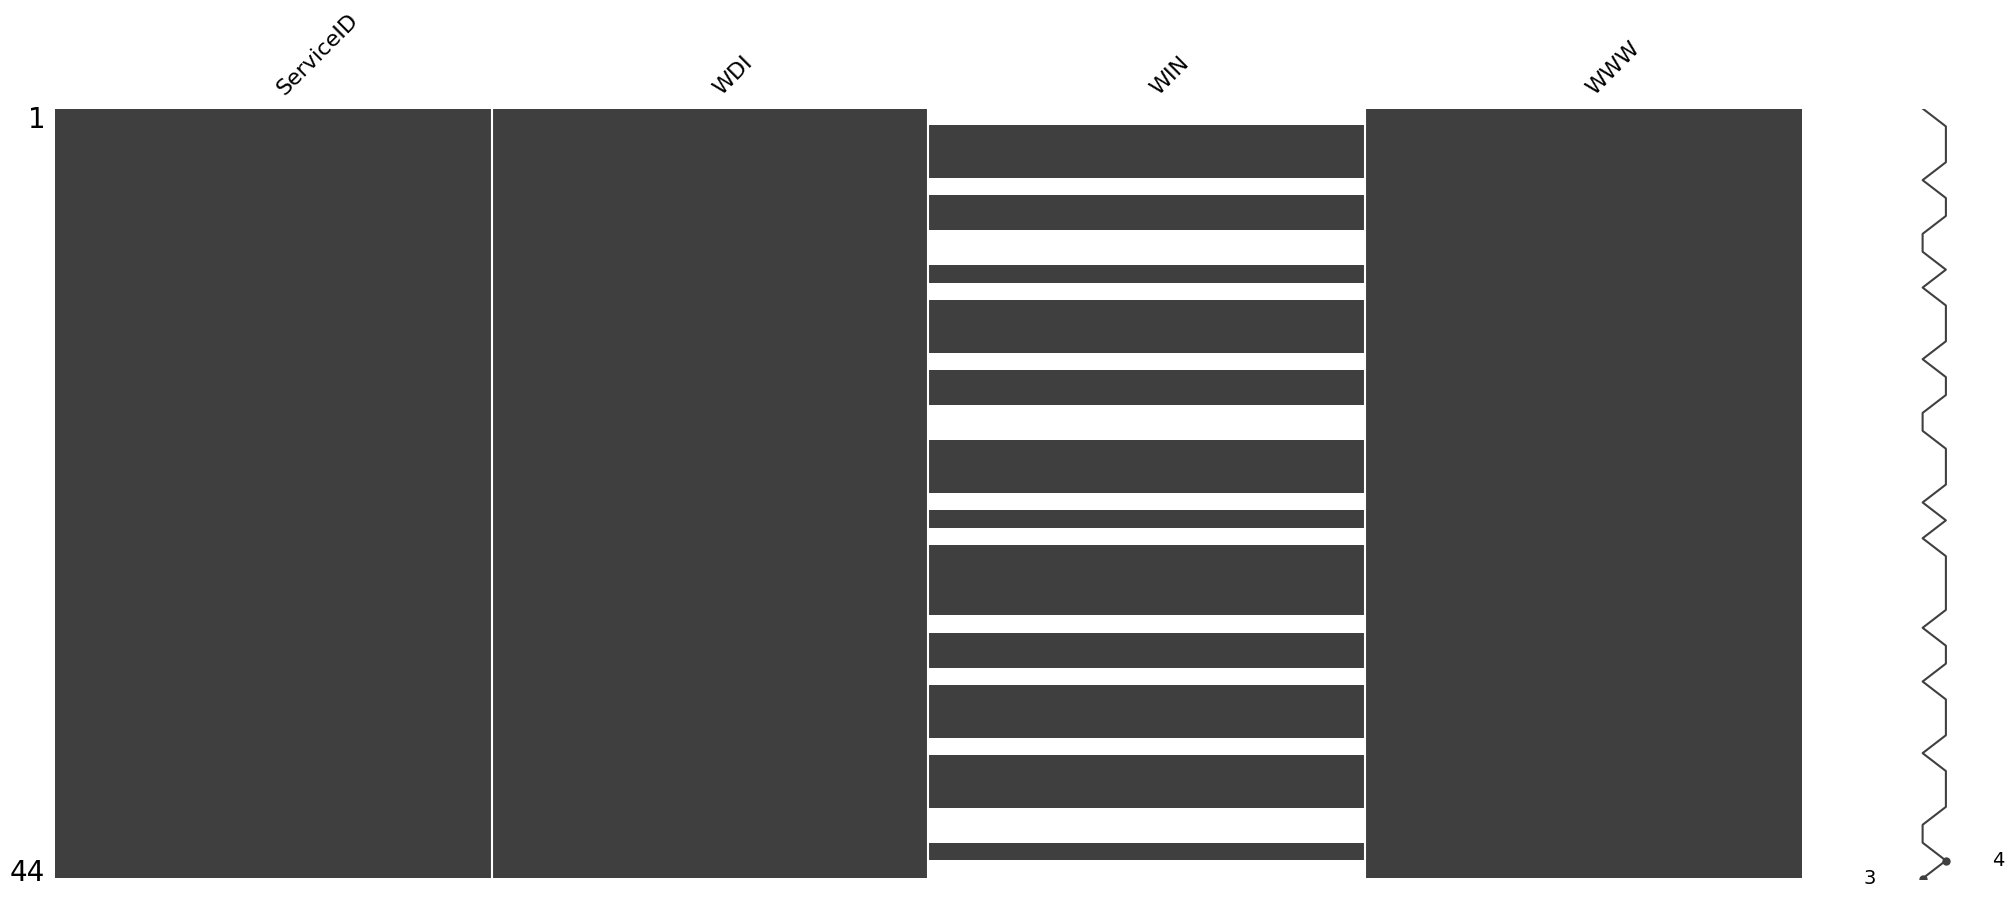

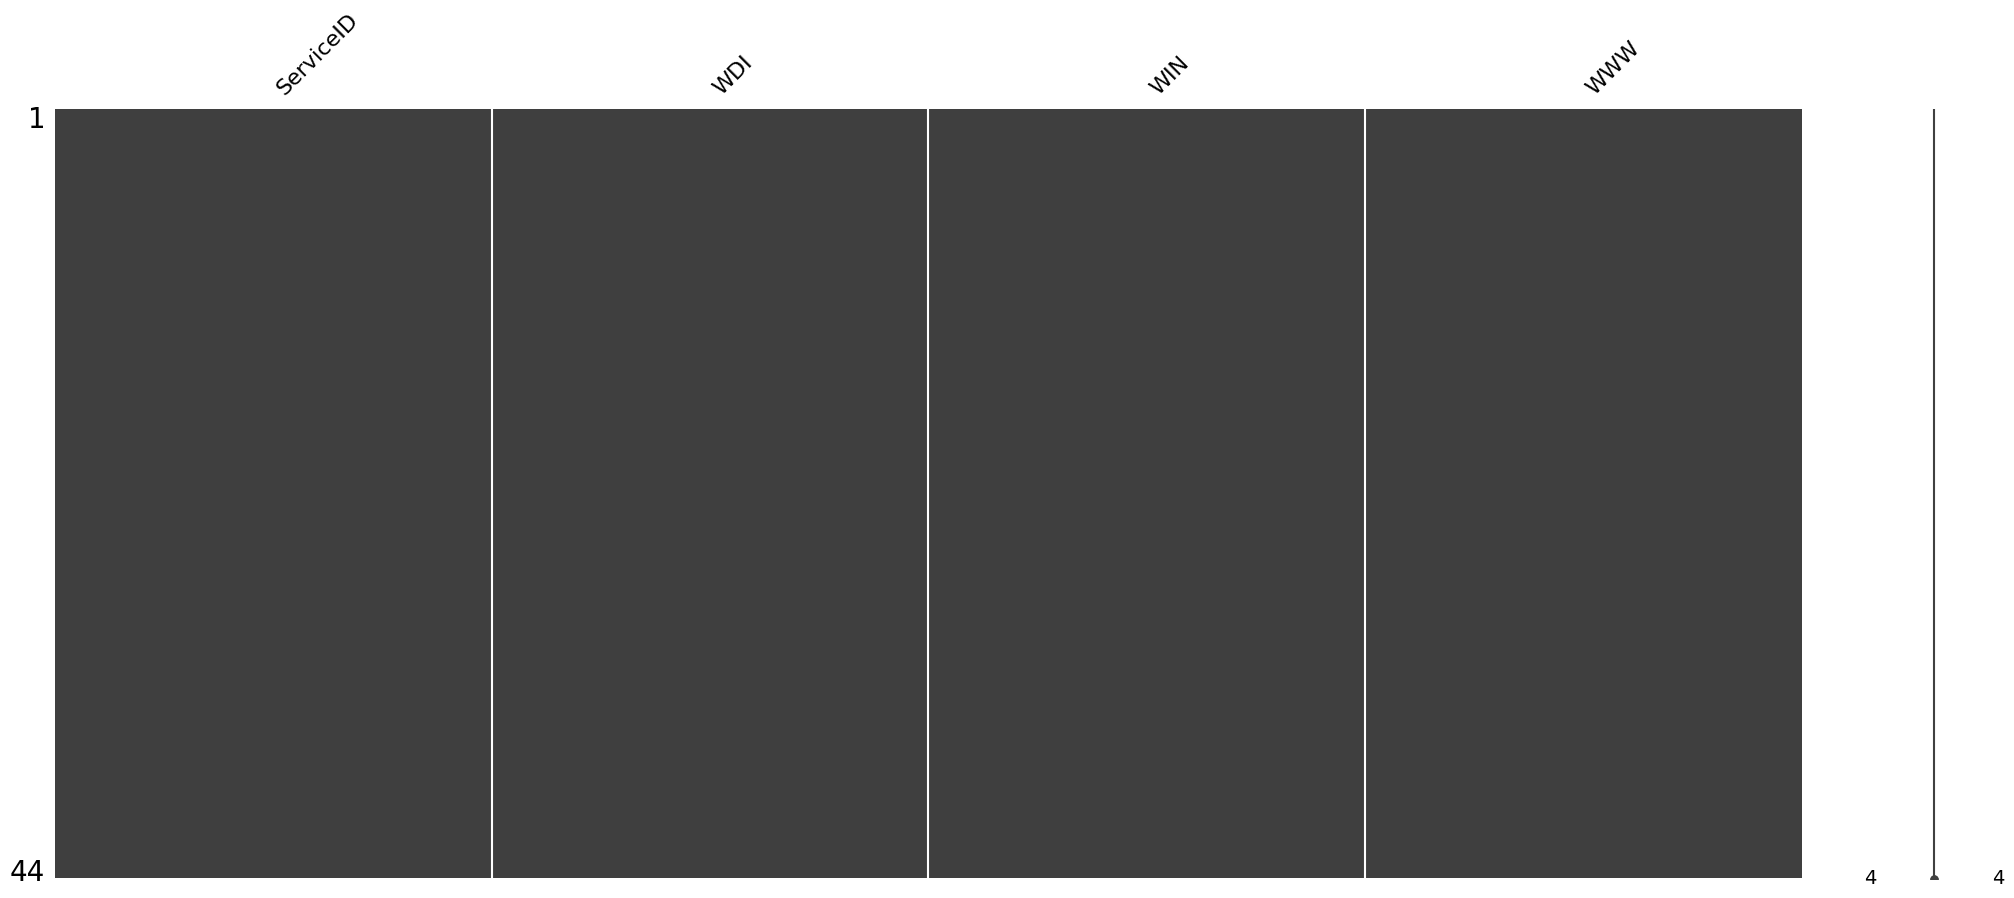

In [10]:
# Where GWI factor is not available for WIN, WDI figure is used for both WIN and WWW

# a - not weekly but average over the whole year! 
grouped_df = device_factor.groupby(['PlatformID', 'ServiceID']).agg(
    Avg_GWI_Site_to_People_Factor=('GWI Site to People Factor', 'mean'),
    Count=('GWI Site to People Factor', 'count')
).reset_index()
display(grouped_df.sample())
crosstab = pd.crosstab(grouped_df['ServiceID'], grouped_df['PlatformID'], 
                       values=grouped_df['Avg_GWI_Site_to_People_Factor'], 
                       aggfunc='sum').reset_index()
display(crosstab[crosstab['WIN'].isna()].sample(5))
missing_win_services = crosstab[crosstab['WIN'].isna()]['ServiceID'].unique().tolist()

msno.matrix(crosstab)

############ adding WIN
start = len(device_factor)
services_noWIN = device_factor[device_factor['ServiceID'].isin(missing_win_services)]
temp = services_noWIN[services_noWIN['PlatformID'] == 'WDI']
test_val = len(temp)
temp.loc[:, 'PlatformID'] = 'WIN'
device_factor_ready = pd.concat([device_factor, temp])
end = len(device_factor_ready)

test_functions.test_adding_WWW(start, test_val, end, '3_Site_7', 'adding WIN to device factor calculation')

############

# a - not weekly but average over the whole year! 
grouped_df = device_factor_ready.groupby(['PlatformID', 'ServiceID']).agg(
    Avg_GWI_Site_to_People_Factor=('GWI Site to People Factor', 'mean'),
    Count=('GWI Site to People Factor', 'count')
).reset_index()
crosstab = pd.crosstab(grouped_df['ServiceID'], grouped_df['PlatformID'], 
                       values=grouped_df['Avg_GWI_Site_to_People_Factor'], 
                       aggfunc='sum').reset_index()
msno.matrix(crosstab)


In [11]:
################################# adding services to device factor only
service_additions = {# only DF
                     #'AX2': 'ELT', 
                     'GNL': 'WOR' 
                    }
# create Service ENW from WSE
i = 8
for service in service_additions.keys():
    # filter to service in key e.g. AX2
    start = len(device_factor_ready)
    temp = device_factor_ready[(device_factor_ready['ServiceID'] == service)]
    test_val = len(temp)
    print(f"{service}: {temp.shape}")
    # set that to the service in values e.g. 'ELT'
    temp.loc[:, 'ServiceID'] = service_additions[service]
    device_factor_ready = pd.concat([device_factor_ready, temp])
    end = len(device_factor_ready)

    test_number = f"3_Site_{i}"
    test_step = f"adding {service_additions[service]} to device factor calculation"
    test_functions.test_adding_WWW(start, test_val, end, test_number, test_step)
    i += 1


GNL: (156, 7)
passed the test! 
...updating logbook...



In [12]:
# add a test for rows occuring only once
device_factor_ready.groupby(['w/c', 'PlatformID', 'ServiceID']).size()

w/c         PlatformID  ServiceID
2024-04-01  WDI         AFA          1
                        AMH          1
                        ARA          1
                        AX2          1
                        AZE          1
                                    ..
2025-03-24  WWW         UZB          1
                        VIE          1
                        WOR          1
                        WSE          1
                        YOR          1
Length: 6876, dtype: int64

In [13]:
# leaving out the replacement of HAUSA with chartbeat data

In [14]:
# Summing up uniques for each week/service/platform/country
df_grouped = reach_data.groupby(['YearGAE', 'w/c', 'ServiceID', 'PlatformID', 'PlaceID'])['m_unique_visitors'].sum().reset_index()
print(df_grouped.shape)

test_step = 'checking hierarchy for m_unique_visitors before device factor is applied'
# SERVICE hierarchy issues
service_hierarchy_issues = test_functions.test_hierarchy_reach('3_Site_10', 
                                                               'Service', 
                                                               gam_info, 
                                                               df_grouped, 
                                                               ['YearGAE', 'w/c', 'PlaceID', 'PlatformID'],
                                                               metric_col='m_unique_visitors',
                                                               test_step= test_step, )

# TODO share AX2 hierarchy issues 

# PLATFORM hierarchy issues
platform_hierarchy_issues = test_functions.test_hierarchy_reach(test_number='3_Site_11', 
                                                                mode='Platform', 
                                                                gam_info=gam_info, 
                                                                df=df_grouped,
                                                                key=['YearGAE', 'w/c', 'PlaceID', 'ServiceID'],
                                                                metric_col='m_unique_visitors',
                                                                test_step= test_step)

(869639, 6)
...updating logbook...

All tests passed.
...updating logbook...

All tests passed.


In [15]:
file_lookup = {'platform': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_platform.xlsx", 
               'service': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_service.xlsx", }

def fix_hierarchy_issues(people_df, file_lookup):
    #"think this through" I probably need to increase the children first 
    service_diff = pd.read_excel(file_lookup['service'])[['Parent', 'PlatformID', 'PlaceID', 'YearGAE', 'w/c', 'diff']]
    service_diff = service_diff.rename(columns={'Parent': 'ServiceID'})
    people_df = people_df.merge(service_diff, on=['ServiceID', 'PlatformID', 'PlaceID', 'YearGAE', 'w/c',], how='left')
    people_df['diff'] = people_df['diff'].fillna(0)
    people_df['Reach'] = people_df['Reach'] + people_df['diff']
    people_df.drop(columns=['diff'], inplace=True)

    platform_diff = pd.read_excel(file_lookup['platform'])[['Parent', 'ServiceID', 'PlaceID', 'YearGAE', 'w/c', 'diff']]
    platform_diff = platform_diff.rename(columns={'Parent': 'PlatformID'})
    people_df = people_df.merge(platform_diff, on=['ServiceID', 'PlatformID', 'PlaceID', 'YearGAE', 'w/c',], how='left') 
    people_df['diff'] = people_df['diff'].fillna(0)
    people_df['Reach'] = people_df['Reach'] + people_df['diff']
    people_df.drop(columns=['diff'], inplace=True)
    return people_df

In [16]:
# TODO share Platform hierarchy issues 

# remove where countries are missing 
df_grouped = df_grouped[df_grouped['PlaceID'].notna()]
print(df_grouped.shape)
people_df = df_grouped.merge(device_factor_ready[['w/c', 'ServiceID', 'PlatformID', 
                                                    'GWI Site to People Factor']], 
                             on=['w/c', 'ServiceID', 'PlatformID'], 
                             how='left',
                             indicator=True)
# no device factor 
to_analyse = people_df[people_df['_merge'] == 'left_only']
print(f"{len(to_analyse)} reach values don't have a device factor associated ")
to_analyse.to_excel(f"../test/specific/{gam_info['file_timeinfo']}_reach_withOut_deviceFactor.xlsx")
people_df = people_df.drop(columns='_merge').fillna(value={'GWI Site to People Factor': 0})
#

people_df['Reach'] = people_df['m_unique_visitors'] * (1 - people_df['GWI Site to People Factor'])
try:
    file_lookup = {'platform': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_platform.xlsx", 
               'service': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_service.xlsx", }

    people_df = fix_hierarchy_issues(people_df, file_lookup)

    # second iteration because after the first WWW might have become smaller than WDI etc 
    file_lookup = {'platform': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_platform2.xlsx", 
               'service': f"ugly_adjustments/{gam_info['file_timeinfo']}_hierarchy_adjustments_service2.xlsx", }

    people_df = fix_hierarchy_issues(people_df, file_lookup)

except:
    print("couldn't change hierarchy issues - may be no change file stored?")

service_creator = {
    'ENW': ['WSE'],
    'ENG': ['WSE', 'GNL'],
    'EN2': ['WSE', 'GNL', 'WOR'],
    'ANW': ['AX2', 'WSE'],
    'ANY': ['ANW', 'GNL'],
    'TOT': ['ANW', 'GNL', 'MA-'],
    'ALL': ['TOT', 'WOR']
}

for service_id, service_children in service_creator.items():
    print(service_id)
    temp = people_df[people_df['ServiceID'].isin(service_children)]
    temp = temp.groupby(['YearGAE', 'w/c', 'PlatformID', 'PlaceID'])['Reach'].sum().reset_index()
    temp['ServiceID'] = service_id

    people_df = pd.concat([people_df, temp])

(869639, 6)
0 reach values don't have a device factor associated 
ENW
ENG
EN2
ANW
ANY
TOT
ALL


In [17]:
people_df[(people_df['ServiceID'].isin(['AX2', 'ARA'])) & 
          (people_df['PlatformID']=='WWW') &  
          (people_df['PlaceID']=='EGY') #&  
#          (people_df['w']==42) 
]

,YearGAE,w/c,ServiceID,PlatformID,PlaceID,m_unique_visitors,GWI Site to People Factor,Reach
969,2025.0,2024-04-01,ARA,WWW,EGY,646006.0,0.068090,602019.138295
1617,2025.0,2024-04-01,AX2,WWW,EGY,664036.0,0.101948,602019.138295
17493,2025.0,2024-04-08,ARA,WWW,EGY,675213.0,0.053888,638826.978754
18144,2025.0,2024-04-08,AX2,WWW,EGY,695580.0,0.108157,638826.978754
34297,2025.0,2024-04-15,ARA,WWW,EGY,793790.0,0.078968,731106.270823
...,...,...,...,...,...,...,...,...
820899,2025.0,2025-03-10,AX2,WWW,EGY,517534.0,0.111479,459839.668436
837047,2025.0,2025-03-17,ARA,WWW,EGY,769139.0,0.171115,703514.350523
837695,2025.0,2025-03-17,AX2,WWW,EGY,790758.0,0.127281,716919.502655
853981,2025.0,2025-03-24,ARA,WWW,EGY,586103.0,0.155651,548031.057495


In [18]:
test_step = 'checking hierarchy for reach'
# SERVICE hierarchy issues
service_hierarchy_issues = test_functions.test_hierarchy_reach('3_Site_12', 
                                                               'Service', 
                                                               gam_info, 
                                                               people_df.drop(columns=['GWI Site to People Factor', 'm_unique_visitors']), 
                                                               ['YearGAE', 'w/c', 'PlaceID', 'PlatformID'],
                                                               metric_col='Reach',
                                                               test_step=test_step)

# TODO share AX2 hierarchy issues 

# PLATFORM hierarchy issues
platform_hierarchy_issues = test_functions.test_hierarchy_reach(test_number='3_Site_13', 
                                                                mode='Platform', 
                                                                gam_info=gam_info, 
                                                                df=people_df.drop(columns=['GWI Site to People Factor', 'm_unique_visitors']),
                                                                key=['YearGAE', 'w/c', 'PlaceID', 'ServiceID'],
                                                                metric_col='Reach',
                                                                test_step=test_step)

# TODO share Platform hierarchy issues 

...updating logbook...

All tests passed.
...updating logbook...

All tests passed.


In [19]:
# FINALS

# trended
############################# TESTING start
main_df = people_df.copy()
test_step = 'final_testig_reachDF'

# test all weeks present
test_functions.test_weeks_presence_per_account('w/c', ['ServiceID'], main_df, week_tester, 
                                               '3_Site_14', test_step)

# test placeID in lookup
test_functions.test_inner_join(main_df, country_codes, ['PlaceID'], 
                               '3_Site_15', test_step, focus='left')

# test platformID in lookup
test_functions.test_inner_join(main_df, platform_codes, ['PlatformID'], 
                               '3_Site_16', test_step, focus='left')

# test serviceID in lookup
test_functions.test_inner_join(main_df, service_codes, ['ServiceID'], 
                               '3_Site_17', test_step, focus='left')

############################# TESTING end

#people_df
cols = ['YearGAE', 'w/c', 'ServiceID', 'PlatformID', 'PlaceID', 'Reach']
people_df[cols].to_csv(f"../data/singlePlatform/output/weekly/{gam_info['file_timeinfo']}_site_reach_weekly.csv")


# average bb
# test that all weeks are present, else add them in 
gam_df = people_df.groupby(['YearGAE', 'ServiceID', 'PlatformID', 'PlaceID'])['Reach'].sum().reset_index()

gam_df['Reach'] = gam_df['Reach']/gam_info['number_of_weeks']
gam_df.to_excel(f"../data/singlePlatform/output/{gam_info['file_timeinfo']}_site_reach_annual.xlsx")

All weeks are present in the dataset for each group.
...updating logbook...

Inner join test 3_Site_15 successful: No issues found.
...updating logbook...

Inner join test 3_Site_16 successful: No issues found.
...updating logbook...

Inner join test 3_Site_17 successful: No issues found.
...updating logbook...



In [20]:
people_df[(people_df['PlatformID'] == 'WWW') &
            (people_df['ServiceID'] == 'GNL') &
            (people_df['PlaceID'] == 'USA') 
        ]['Reach'].sum()/gam_info['number_of_weeks']

np.float64(17933868.22562685)

In [21]:
people_df[(people_df['PlatformID'] == 'WWW') &
            (people_df['ServiceID'] == 'GNL') &
            (people_df['PlaceID'] == 'USA') 
        ]['Reach'].mean()

np.float64(17933868.22562685)

In [22]:
gam_df[(gam_df['PlatformID'] == 'WWW') &
            (gam_df['ServiceID'] == 'GNL') &
            (gam_df['PlaceID'] == 'USA') 
        ]

,YearGAE,ServiceID,PlatformID,PlaceID,Reach
9128,2025.0,GNL,WWW,USA,1.793387e+07


# analysis 

In [23]:
# TO DO create an analysis that compares WWW & (WIN + WDI)

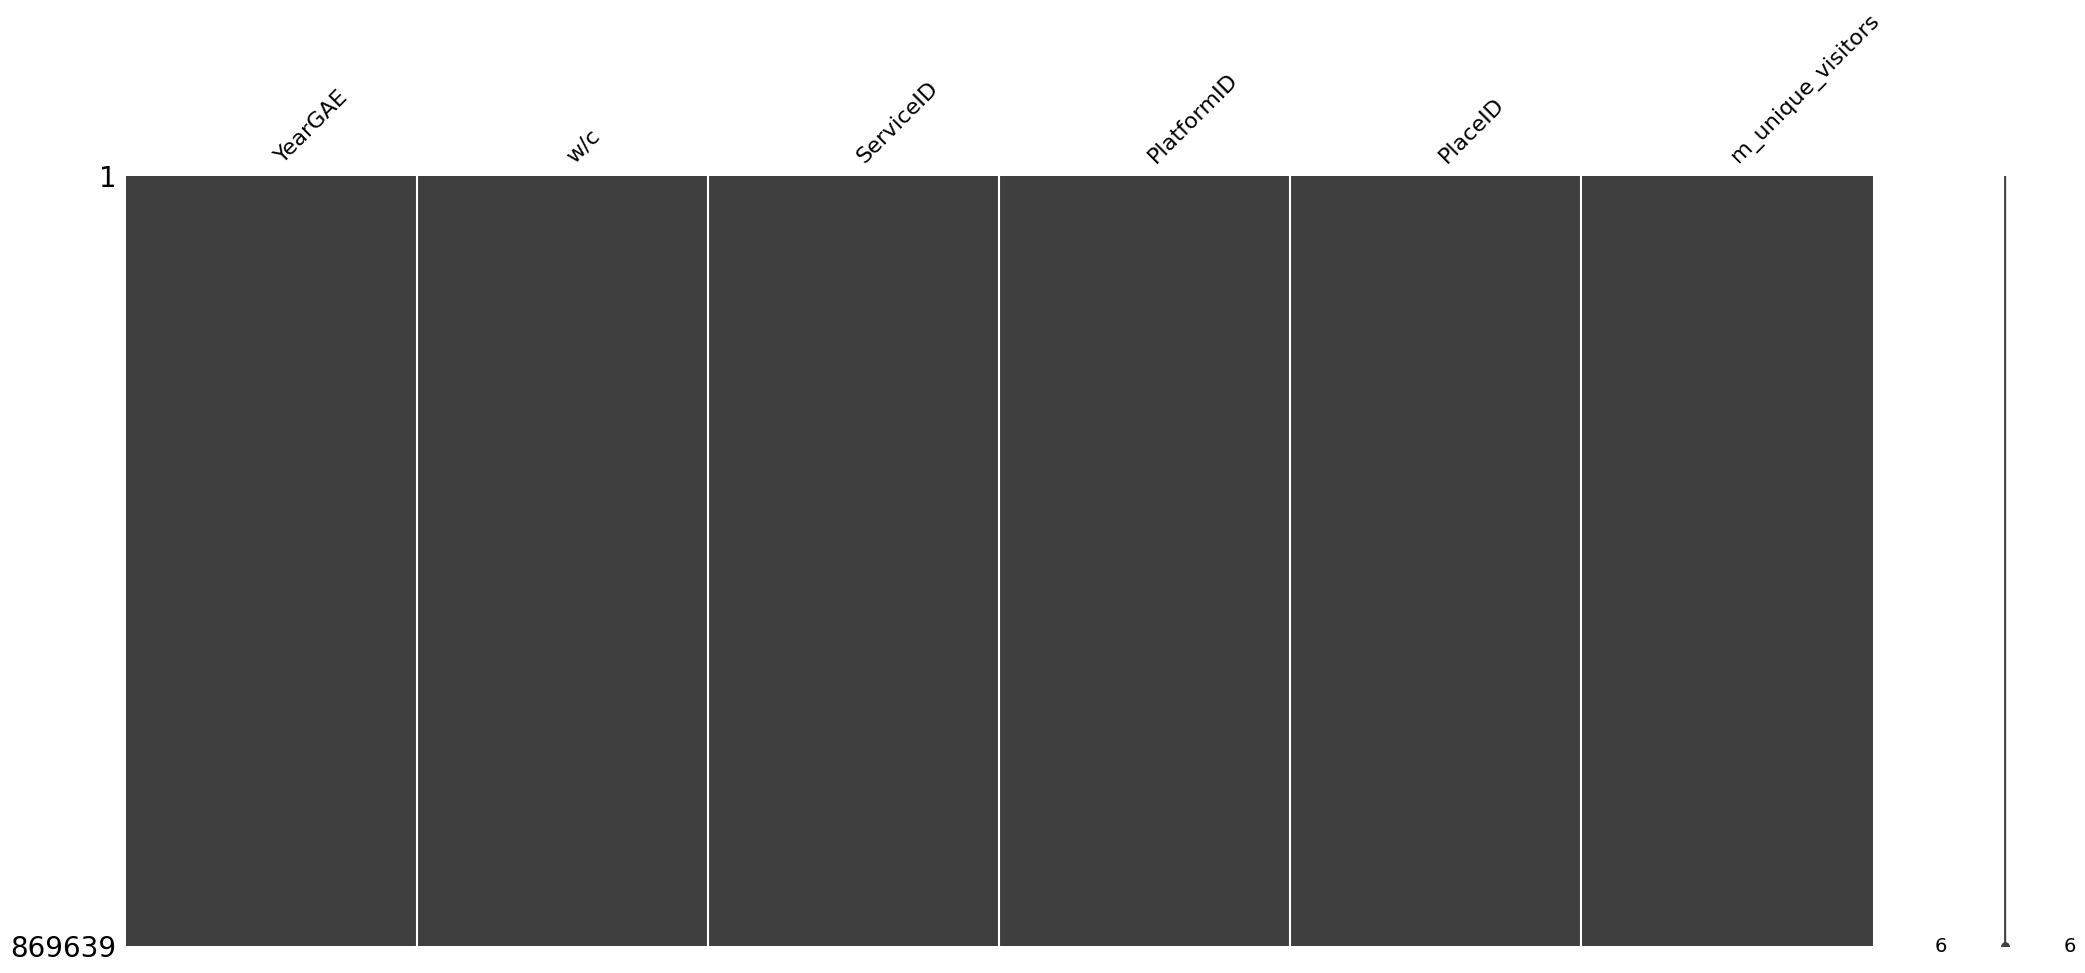

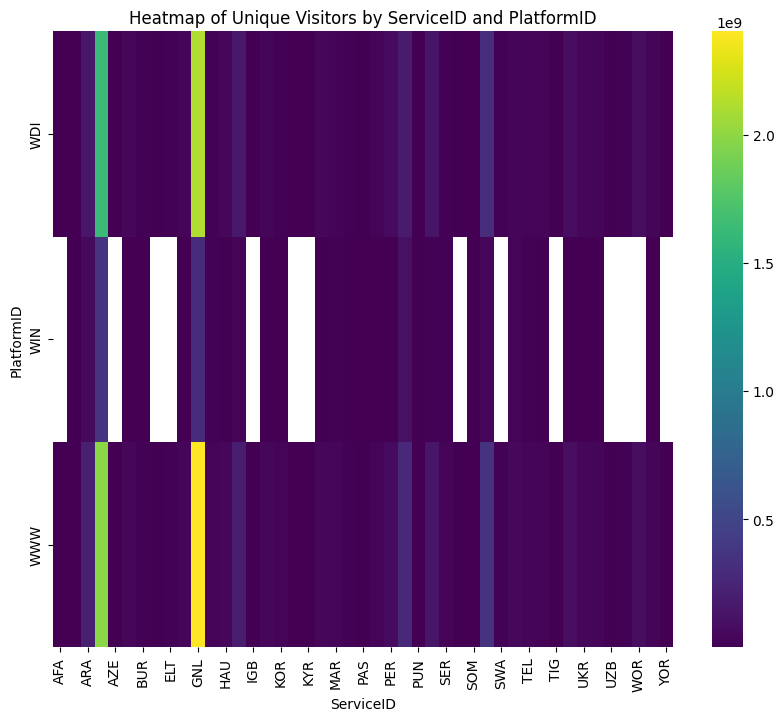

In [24]:
msno.matrix(df_grouped)
heatmap_data = df_grouped.pivot_table(index='PlatformID', columns='ServiceID', values='m_unique_visitors', aggfunc='sum')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, fmt="g", cmap="viridis")
plt.title('Heatmap of Unique Visitors by ServiceID and PlatformID')
plt.show()

In [25]:

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_grouped[~df_grouped['ServiceID'].isin(['GNL', 'WOR'])].sort_values('m_unique_visitors', ascending=False).head(50)

,YearGAE,w/c,ServiceID,PlatformID,PlaceID,m_unique_visitors
151234,2025.00,2024-06-03,AX2,WWW,IND,10271590.00
586952,2025.00,2024-12-02,AX2,WWW,IND,9285881.00
837726,2025.00,2025-03-17,AX2,WWW,IND,8942015.00
150791,2025.00,2024-06-03,AX2,WDI,IND,8398229.00
603729,2025.00,2024-12-09,AX2,WWW,IND,8274430.00
737290,2025.00,2025-02-03,AX2,WWW,IND,8165611.00
620450,2025.00,2024-12-16,AX2,WWW,IND,7903764.00
553457,2025.00,2024-11-18,AX2,WWW,IND,7786437.00
570173,2025.00,2024-11-25,AX2,WWW,IND,7726404.00
720413,2025.00,2025-01-27,AX2,WWW,BRA,7639206.00


In [26]:
df_grouped[(df_grouped['PlaceID'] == 'IND') & 
            (df_grouped['ServiceID'] == 'HIN') #& 
#            (df_grouped['Week Number'] == 23)
]

,YearGAE,w/c,ServiceID,PlatformID,PlaceID,m_unique_visitors
4996,2025.00,2024-04-01,HIN,WDI,IND,2509722.00
5113,2025.00,2024-04-01,HIN,WIN,IND,161620.00
5219,2025.00,2024-04-01,HIN,WWW,IND,2671283.00
21502,2025.00,2024-04-08,HIN,WDI,IND,2355052.00
21622,2025.00,2024-04-08,HIN,WIN,IND,89722.00
...,...,...,...,...,...,...
841175,2025.00,2025-03-17,HIN,WIN,IND,686186.00
841285,2025.00,2025-03-17,HIN,WWW,IND,4138923.00
857906,2025.00,2025-03-24,HIN,WDI,IND,2365518.00
858030,2025.00,2025-03-24,HIN,WIN,IND,347963.00


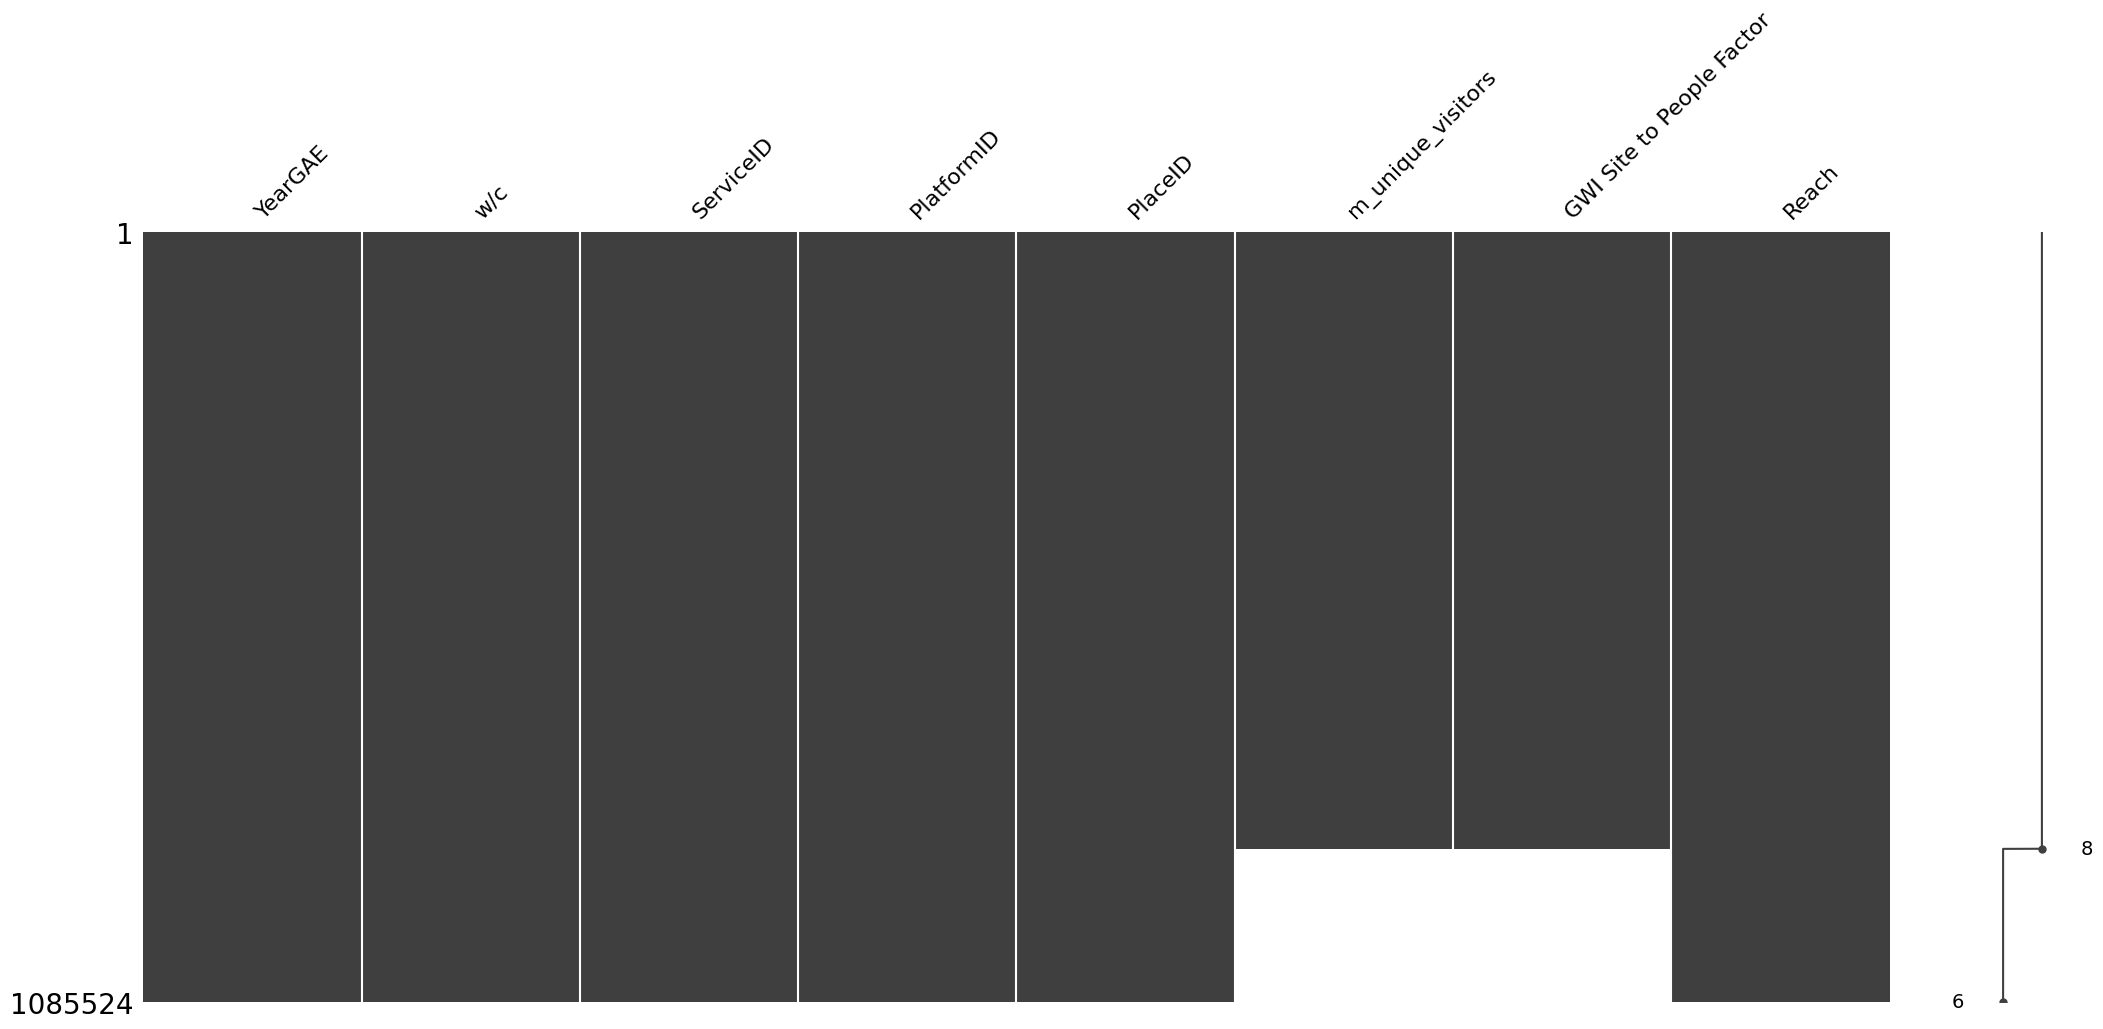

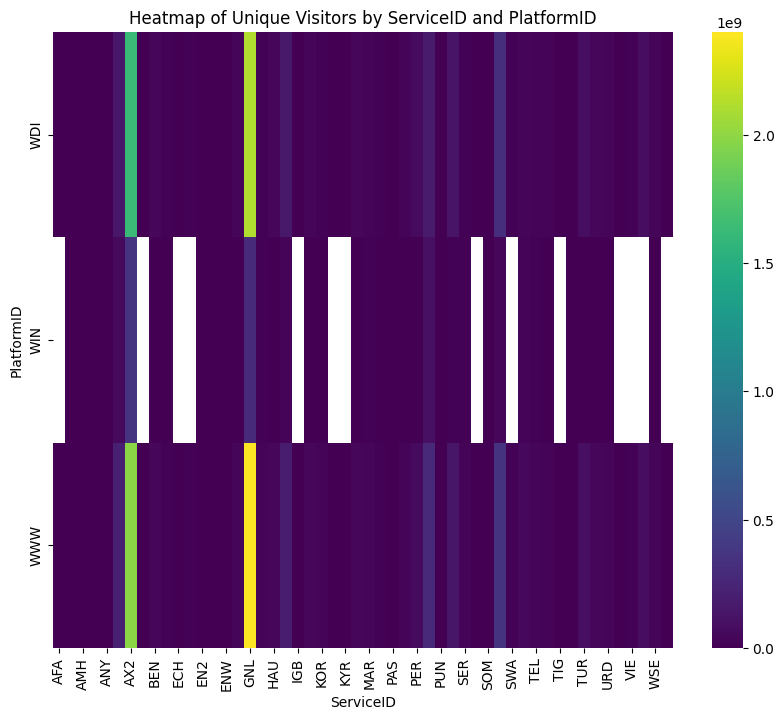

In [27]:
msno.matrix(people_df)
heatmap_data = people_df.pivot_table(index='PlatformID', 
                                     columns='ServiceID', 
                                     values='m_unique_visitors', 
                                     aggfunc='sum')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, fmt="g", cmap="viridis")
plt.title('Heatmap of Unique Visitors by ServiceID and PlatformID')
plt.show()

In [28]:
people_df[(people_df['PlaceID'] == 'IND') & 
            (people_df['ServiceID'] == 'HIN') #& 
#            (people_df['Week Number'] == 23)
]

,YearGAE,w/c,ServiceID,PlatformID,PlaceID,m_unique_visitors,GWI Site to People Factor,Reach
4996,2025.00,2024-04-01,HIN,WDI,IND,2509722.00,0.02,2448021.66
5113,2025.00,2024-04-01,HIN,WIN,IND,161620.00,0.04,154640.51
5219,2025.00,2024-04-01,HIN,WWW,IND,2671283.00,0.03,2602624.69
21502,2025.00,2024-04-08,HIN,WDI,IND,2355052.00,0.03,2293262.34
21622,2025.00,2024-04-08,HIN,WIN,IND,89722.00,0.04,85855.11
...,...,...,...,...,...,...,...,...
841175,2025.00,2025-03-17,HIN,WIN,IND,686186.00,0.01,676265.56
841285,2025.00,2025-03-17,HIN,WWW,IND,4138923.00,0.05,3933017.16
857906,2025.00,2025-03-24,HIN,WDI,IND,2365518.00,0.05,2253317.02
858030,2025.00,2025-03-24,HIN,WIN,IND,347963.00,0.03,338188.44


In [29]:
6336004.14/(6050922.91+285244.72)

0.9999741973366951